# From Image to Real

In this colab we will use a deep neural network to transform points in the image world to points in the real world, for that we will recive the points in the image world, the camera position and the neuronal network should be responsible to "find" the equations to perform the transformation

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Get the training file from the drive and unzip it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Colab-Notebooks/Project-NN/training-data.tar.gz .
!tar xvzf training-data.tar.gz

training_data.tf


Create a function to normalize the data.

In [ ]:
def norm(x):
  norm_data = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
  return norm_data, x.min(axis=0), x.max(axis=0)

Load the training and test data to a numpy array.

In [ ]:
data_collect = np.loadtxt('training_data.tf', dtype=np.float32, comments='#')
data_collect, min, max = norm(data_collect)

np.random.shuffle(data_collect)
train_size = int(data_collect.shape[0] * 0.8)

print('Train size: %d -- Test size: %d' % (train_size, data_collect.shape[0] - train_size))

# Train data.
train_examples = data_collect[:train_size, 0:5]
train_labels = data_collect[:train_size, 5:8]

# Test data.
test_examples = data_collect[train_size:, 0:5]
test_labels = data_collect[train_size:, 5:8]

Train size: 311228 -- Test size: 77807


Create and execute a model.

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(1,5)),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(3)
                             ])

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae', 'mse', 'acc'])

Model structure:

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 64)             384       
_________________________________________________________________
dense_9 (Dense)              (None, 1, 128)            8320      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 3)              195       
Total params: 17,155
Trainable params: 17,155
Non-trainable params: 0
_________________________________________________________________


Create a callback for the model.

In [ ]:
REQUIRE_MSE = 1.0e-05

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mse') < REQUIRE_MSE:
      msg = '\nMean square errer is low than %lf, so cancelling training!' % REQUIRE_MSE
      print(msg)
      self.model.stop_training = True

callbacks = myCallback()

Train the model.

In [ ]:
history = model.fit(train_examples, 
                    train_labels, 
                    validation_data=(test_examples, test_labels), 
                    epochs=100, 
                    callbacks=[callbacks])

Epoch 1/100
9726/9726 [==============================] - 28s 3ms/step - loss: 0.0580 - mae: 0.0580 - mse: 0.0095 - acc: 0.8705 - val_loss: 0.0248 - val_mae: 0.0248 - val_mse: 0.0017 - val_acc: 0.9585
Epoch 2/100
9726/9726 [==============================] - 28s 3ms/step - loss: 0.0224 - mae: 0.0224 - mse: 0.0013 - acc: 0.9598 - val_loss: 0.0144 - val_mae: 0.0144 - val_mse: 4.9014e-04 - val_acc: 0.9744
Epoch 3/100
9726/9726 [==============================] - 28s 3ms/step - loss: 0.0158 - mae: 0.0158 - mse: 5.4090e-04 - acc: 0.9710 - val_loss: 0.0148 - val_mae: 0.0148 - val_mse: 4.3963e-04 - val_acc: 0.9729
Epoch 4/100
9726/9726 [==============================] - 28s 3ms/step - loss: 0.0131 - mae: 0.0131 - mse: 3.5596e-04 - acc: 0.9762 - val_loss: 0.0115 - val_mae: 0.0115 - val_mse: 2.8095e-04 - val_acc: 0.9787
Epoch 5/100
9726/9726 [==============================] - 27s 3ms/step - loss: 0.0116 - mae: 0.0116 - mse: 2.7378e-04 - acc: 0.9796 - val_loss: 0.0104 - val_mae: 0.0104 - val_mse: 2

Plot mean square error evolution.

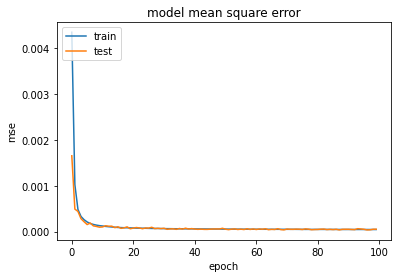

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean square error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate first 10 items in the test set.

In [ ]:
def back(x, min, max):
  return ((x + min) * (max - min))

In [ ]:
expect = back(test_labels[:10, :], min[5:8], max[5:8])
ans = model.predict(test_examples[:10, :])
rcv = back(ans, min[5:8], max[5:8])
print(expect -rcv)

[[ 1.9389648e+00  1.7812500e+00  5.5887401e-03]
 [ 7.0502930e+00  4.0058594e+00 -1.3474733e-02]
 [ 2.5190430e+00  4.4843750e+00  3.1632781e-03]
 [ 1.8603516e+00 -5.2539062e-01  1.5280545e-02]
 [ 3.5346680e+00  1.0468750e+00  1.9084960e-03]
 [ 2.9985352e+00  2.2890625e+00  5.7863444e-03]
 [ 3.5219727e+00  4.2968750e-01  9.2249960e-03]
 [-1.7866211e+00 -1.7714844e+00 -6.8488121e-03]
 [-3.4619141e-01 -1.1054688e+00  4.9784780e-05]
 [ 3.4565430e+00  2.4667969e+00  3.0574352e-03]]


Clean up the environment.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)